In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

data = pd.read_csv("..\données\drought.csv")
data = data.drop(columns=['0','-9'])
data['DATE'] = pd.to_datetime(data['DATE'],format='d_%Y%m%d')
data['state'] =pd.Categorical(data['state'])
data['DSCI'] = data.D0 + data.D1 + data.D2 + data.D3 + data.D4

# Pour simplifier, nous étudions des séries temporelles univariées
data = data.drop(columns=['D0','D1','D2','D3','D4','W0','W1','W2','W3','W4'])
data

,DATE,state,DSCI
0,1895-01-01,alabama,0.0
1,1895-02-01,alabama,0.0
2,1895-03-01,alabama,0.0
3,1895-04-01,alabama,0.0
4,1895-05-01,alabama,0.0
...,...,...,...
73339,2021-12-01,wyoming,108.7
73340,2022-01-01,wyoming,85.7
73341,2022-02-01,wyoming,86.1
73342,2022-03-01,wyoming,50.0


In [2]:
# Nous nous concentrons d'abord sur les données de l'état de l'Alabama
X = data[data.state=='california'].sort_values('DATE')
X = X.drop(columns=['state']).sort_values('DATE').set_index('DATE')

Dans la première étape, nous dessinons le diagramme acf et le diagramme pacf pour juger si la séquence est une séquence stationnaire

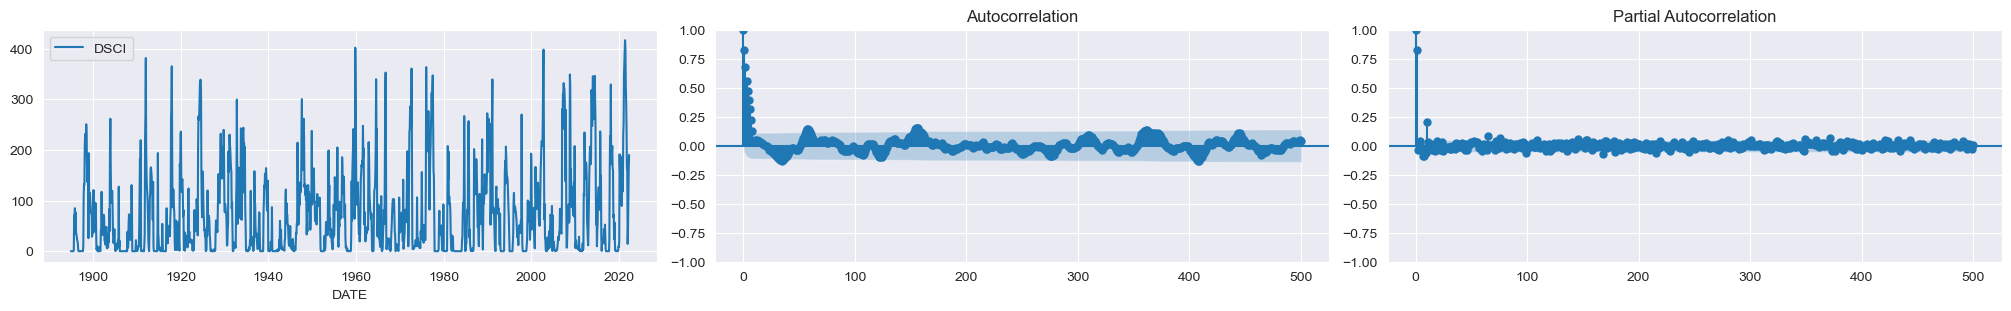

In [3]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

def plot_tri(X,lags=30):
    fig, ax =plt.subplots(1,3,constrained_layout=True, figsize=(20, 3))
    sns.lineplot(X, ax=ax[0])
    plot_acf(X,lags=lags, ax=ax[1])
    plot_pacf(X,lags=lags,method='ywm', ax=ax[2])

plot_tri(X,500)

On peut voir qu'il y a une certaine périodicité dans le graphe acf, donc la séquence n'est pas une séquence stationnaire, et nous devons la STL pour la stabiliser

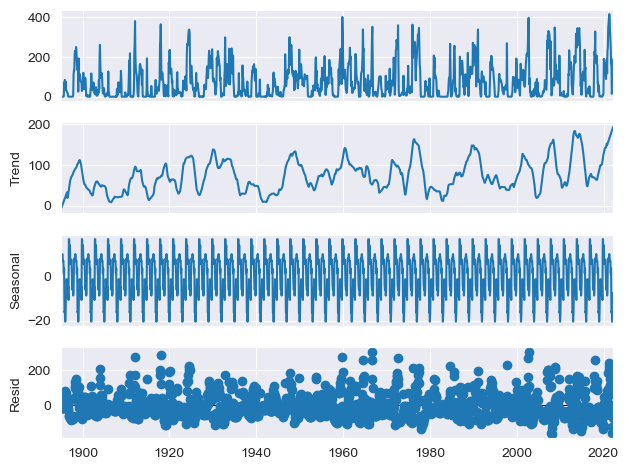

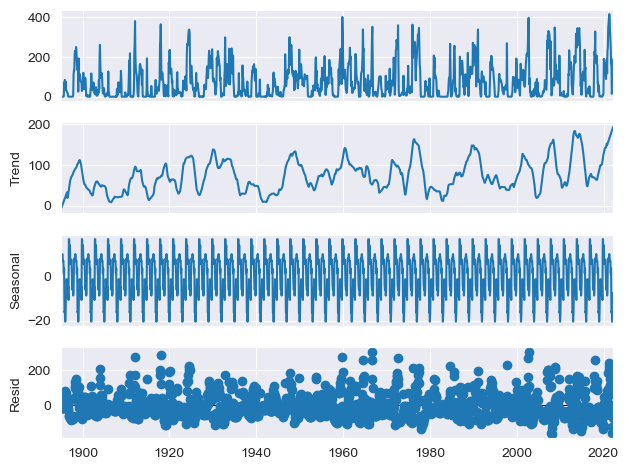

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
Xd = seasonal_decompose(X, model='additive', extrapolate_trend='freq',period = 36)
Xd.plot()

A en juger par le diagramme acf est très subjectif, on peut utiliser le test de stationnarité pour juger si la séquence est stable

In [5]:
# L'hypothèse nulle du test est que la série est non stationnaire
from statsmodels.tsa.stattools import adfuller
adfuller(Xd.trend)

(-6.024726555464118,
 1.4651669972726933e-07,
 10,
 1517,
 {'1%': -3.434667995897907,
  '5%': -2.863447124874016,
  '10%': -2.5677853274099864},
 4518.707059739496)

La valeur de p est inférieure à 0,05, nous sommes donc en mesure de rejeter l'hypothèse nulle
Ensuite, nous devons voir si la séquence après différence est une séquence de bruit blanc
Ici l'hypothèse nulle est que la séquence est une séquence de bruit blanc

In [6]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(Xd.resid, lags=[6,12,36,48,120])

,lb_stat,lb_pvalue
6,1705.952837,0.0
12,2532.439885,0.0
36,3093.000115,0.0
48,3111.565656,0.0
120,3477.054902,0.0


In [109]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(X.DSCI,train_size=0.8,shuffle=False)

Nous pouvons juger les paramètres à travers le diagramme acf, ou utiliser la fonction suivante pour sélectionner automatiquement

In [93]:
import statsmodels.api as sm
trend_evaluate = sm.tsa.arma_order_select_ic(train, ic=['aic', 'bic'], max_ar=20,max_ma=5)
print('train AIC', trend_evaluate.aic_min_order)
print('train BIC', trend_evaluate.bic_min_order)

D:\Programming\Conda_envs\SY09\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Programming\Conda_envs\SY09\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programming\Conda_envs\SY09\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programming\Conda_envs\SY09\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Programming\Conda_envs\SY09\lib\site-p

train AIC (11, 0)
train BIC (10, 0)


D:\Programming\Conda_envs\SY09\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prédiction à l'aide de STL

D:\Programming\Conda_envs\SY09\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Programming\Conda_envs\SY09\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Programming\Conda_envs\SY09\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


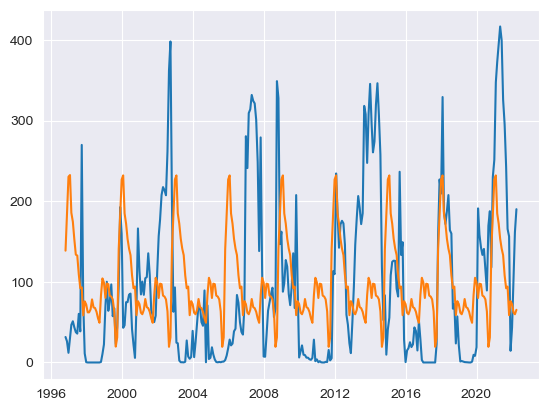

MES: 11980.203323550011


In [116]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.forecasting.stl import STLForecast
stlf = STLForecast(train, ARIMA, period=36 ,model_kwargs=dict(order=(11, 1, 0)))
stlf_res = stlf.fit()
forecast = stlf_res.forecast(len(test))
plt.plot(test)
plt.plot(forecast)
plt.show()
print("MES:", mean_squared_error(test,forecast))

On peut voir que l'effet de prédiction est relativement bon
Ensuite, nous examinons dans quelle mesure le modèle correspond à l'ensemble de formation

<Axes: xlabel='DATE', ylabel='DSCI'>

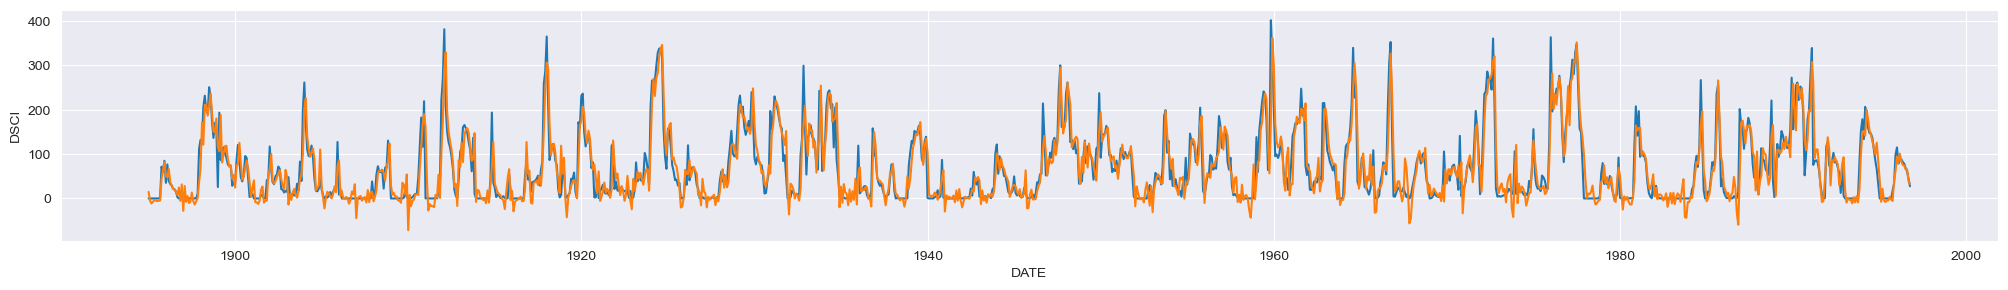

In [111]:
plt.figure(figsize=(25,3))
ax11=sns.lineplot(train)
sns.lineplot(stlf_res.get_prediction().predicted_mean,ax=ax11)

Nous pouvons également utiliser ARIMA directement sans utiliser la méthode STL

In [124]:
train, test = train_test_split(Xd.trend,train_size=0.8,shuffle=False)
model_ARIMA = sm.tsa.statespace.SARIMAX(train,order=(11,1,0)).fit()

D:\Programming\Conda_envs\SY09\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Programming\Conda_envs\SY09\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='DATE', ylabel='trend'>

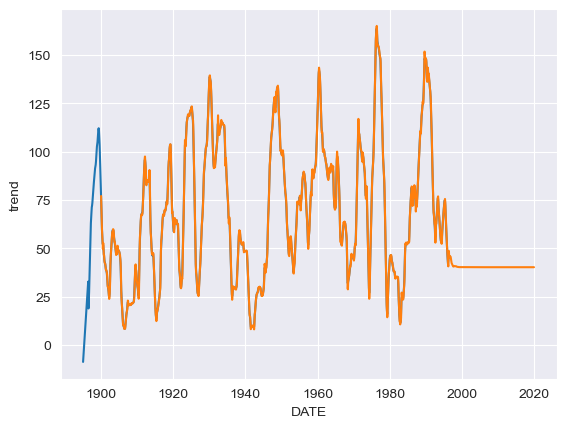

In [127]:
# prdict = model_SARIMAX.forecast(2)
prdict = model_ARIMA.get_prediction(start='1900-01-01',end='2020-01-01')
ax11=sns.lineplot(train)
sns.lineplot(prdict.predicted_mean)

Le modèle ARIMA ne peut prédire que le temps à court terme, le temps à long terme convergera vers la moyenne
Ensuite, nous testons les résidus du modèle pour voir s'ils sont conformes à la distribution gaussienne

<Axes: ylabel='Density'>

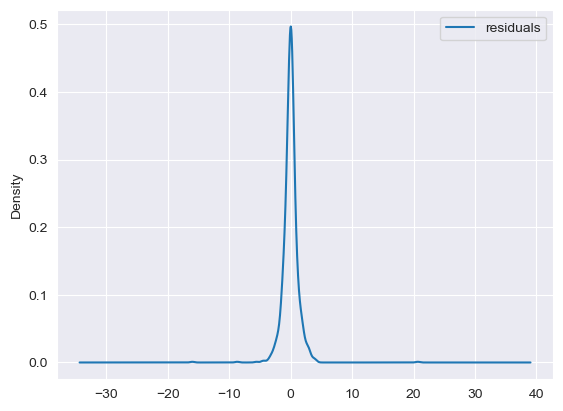

In [128]:
residuals = pd.DataFrame(model_ARIMA.resid, columns=['residuals'])
residuals.plot(kind='kde')

Nous pouvons également prédire une seule valeur à la fois, puis ajouter de nouvelles observations au modèle pour le réajuster

In [129]:
from statsmodels.tsa.arima.model import ARIMA

train,test=train_test_split(X,test_size=0.9,shuffle=False)
test=[int(x) for x in test.DSCI]
history = [int(x) for x in train.DSCI]
predictions = list()
# history


for t in range(len(test)):
    # model = SARIMAX(history,order=(1,1,3),seasonal_order=(2,1,0,12))
    model = ARIMA(history,order=(11,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))

<Axes: >

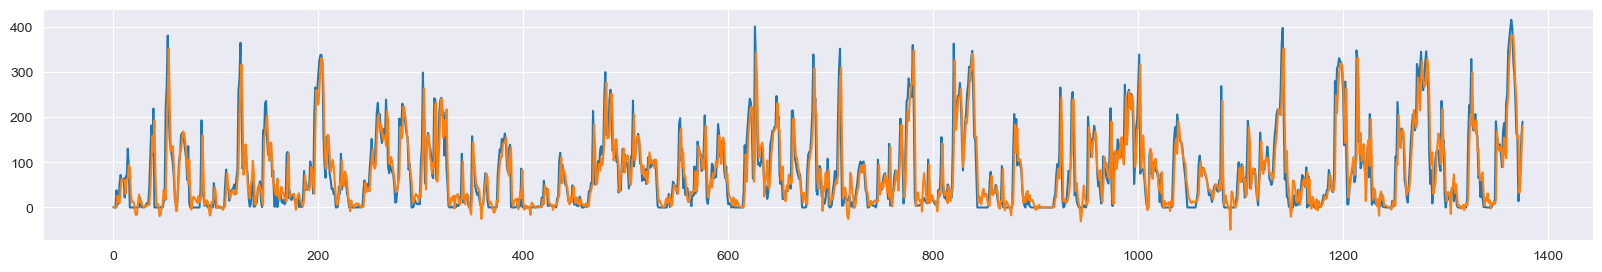

In [131]:
plt.figure(figsize=(20,3))
ax11 = sns.lineplot(test)
sns.lineplot(predictions,ax=ax11)